In [81]:
#We "Pytorchify" the code from makemore_mlp.ipynb, as well as add some visualization code to understand batch normalization
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [82]:
class Linear:
    def __init__(self, fan_in, fan_out, bias = True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        if self.bias is None:
            return [self.weight]
        else:
            return [self.weight, self.bias]
        
class BatchNorm1d:

    def __init__(self, dim, eps = 1e-05, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        #buffers (running mean and variance)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim = True)
            xvar = x.var(0, keepdim = True, unbiased = True)
            
        else:
            xmean = self.running_mean
            xvar = self.running_var
        x_hat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * x_hat + self.beta
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    

    

In [83]:

with open('names.txt', 'r') as f:
    text = f.read()
    words = text.split()

# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
# filter out unwanted characters
chars = [c for c in chars]
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)



{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [84]:
# build the dataset
block_size = 12 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182388, 12]) torch.Size([182388])
torch.Size([22912, 12]) torch.Size([22912])
torch.Size([22846, 12]) torch.Size([22846])


In [85]:
n_embd = 10
n_hidden = 100
block_size = 12

C = torch.randn((vocab_size, n_embd))

layers = [
    Linear(n_embd * block_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)

]

with torch.no_grad():
    layers[-1].weight *= 0.1
    #for all other layers, we apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for l in layers for p in l.parameters()]

for p in parameters:
    p.requires_grad = True


print('number of parameters:', sum(p.nelement() for p in parameters))


number of parameters: 55497


In [86]:
max_steps = 20000
batch_size = 32
lossi = []

for i in range(max_steps):
    ix = torch.randint(0,Xtr.shape[0],(batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    #forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    #backwards pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i < 10000 else 0.01 #learning rate decay
    for p in parameters:
        p.data -= lr * p.grad

    #track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps}: loss = {loss.item():.4f}')
    lossi.append(loss.log10().item())

    break

        
    

      0/20000: loss = 3.2860


layer 1 (      Tanh): mean -0.11, std 0.80, saturated: 31.25%
layer 3 (      Tanh): mean -0.06, std 0.71, saturated: 12.81%
layer 5 (      Tanh): mean -0.02, std 0.70, saturated: 10.44%
layer 7 (      Tanh): mean -0.01, std 0.67, saturated: 6.88%
layer 9 (      Tanh): mean -0.09, std 0.64, saturated: 5.69%


Text(0.5, 1.0, 'activation distribution')

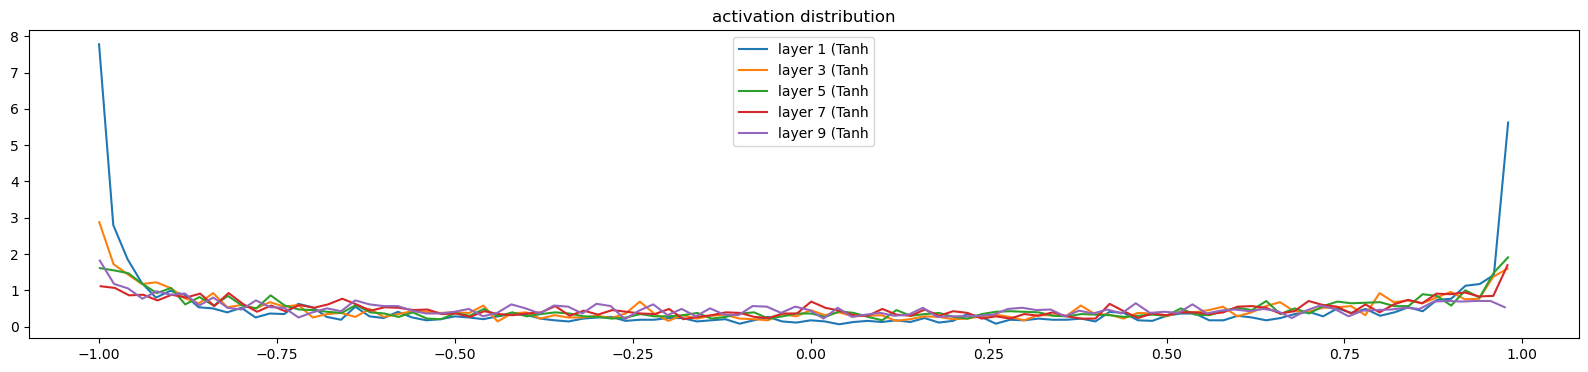

In [87]:
# We visualize histograms of the activations of each layer

plt.figure(figsize=(20, 4)) 
legends = []
for i, layer in enumerate(layers[:-1]): 
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 1 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 3 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 5 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 7 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 9 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%


Text(0.5, 1.0, 'activation distribution')

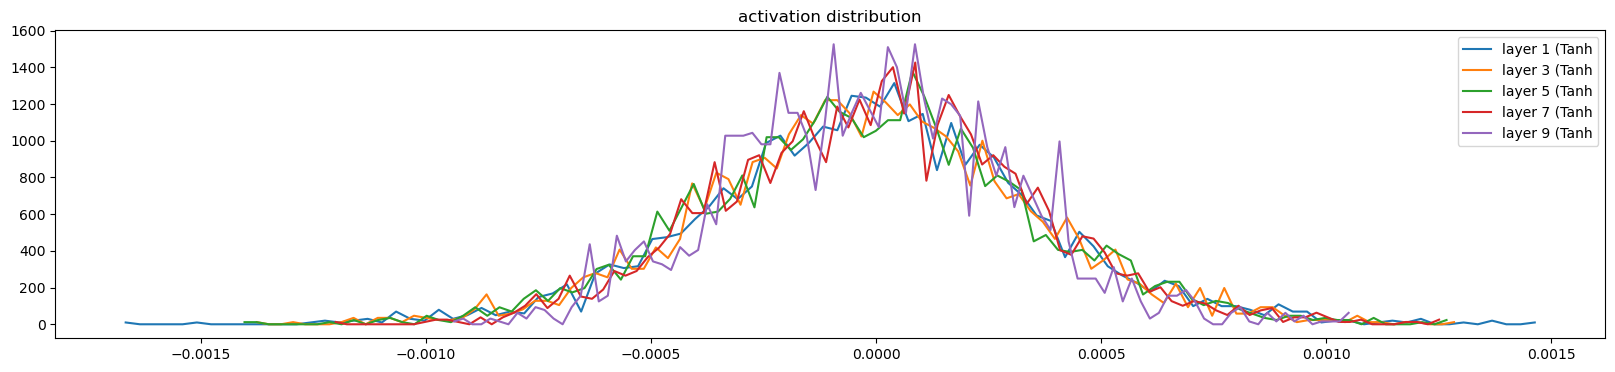

In [88]:
# We visualize histograms of the activations of each layer

plt.figure(figsize=(20, 4)) 
legends = []
for i, layer in enumerate(layers[:-1]): 
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

In [90]:
#now we reintroduce batch normalization

n_embd = 10
n_hidden = 100
block_size = 12

C = torch.randn((vocab_size, n_embd))

layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size)

]

with torch.no_grad():
    #layers[-1].weight *= 0.1
    layers[-1].gamma *= 0.1
    #for all other layers, we apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for l in layers for p in l.parameters()]

for p in parameters:
    p.requires_grad = True


print('number of parameters:', sum(p.nelement() for p in parameters))

number of parameters: 56551


In [91]:
max_steps = 20000
batch_size = 32
lossi = []

for i in range(max_steps):
    ix = torch.randint(0,Xtr.shape[0],(batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    #forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    #backwards pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i < 10000 else 0.01 #learning rate decay
    for p in parameters:
        p.data -= lr * p.grad

    #track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps}: loss = {loss.item():.4f}')
    lossi.append(loss.log10().item())

    break

        
    

      0/20000: loss = 3.3000


layer 2 (      Tanh): mean +0.01, std 0.63, saturated: 2.72%
layer 5 (      Tanh): mean +0.00, std 0.63, saturated: 3.12%
layer 8 (      Tanh): mean +0.00, std 0.63, saturated: 2.88%
layer 11 (      Tanh): mean -0.00, std 0.64, saturated: 2.56%
layer 14 (      Tanh): mean +0.00, std 0.64, saturated: 2.59%


Text(0.5, 1.0, 'activation distribution')

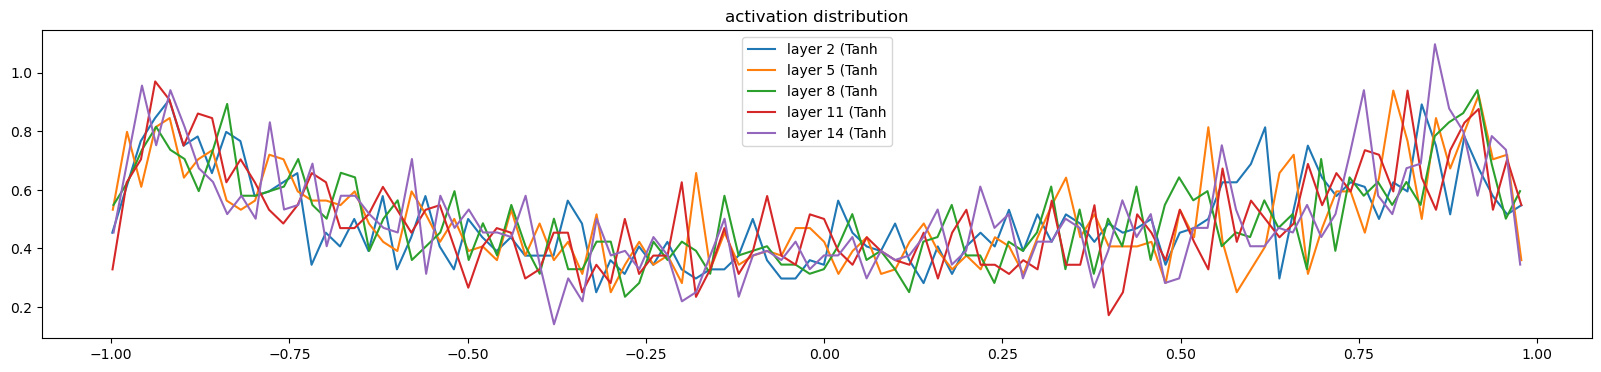

In [92]:
# We visualize histograms of the activations of each layer

plt.figure(figsize=(20, 4)) 
legends = []
for i, layer in enumerate(layers[:-1]): 
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 5 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 8 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 11 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 14 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%


Text(0.5, 1.0, 'activation distribution')

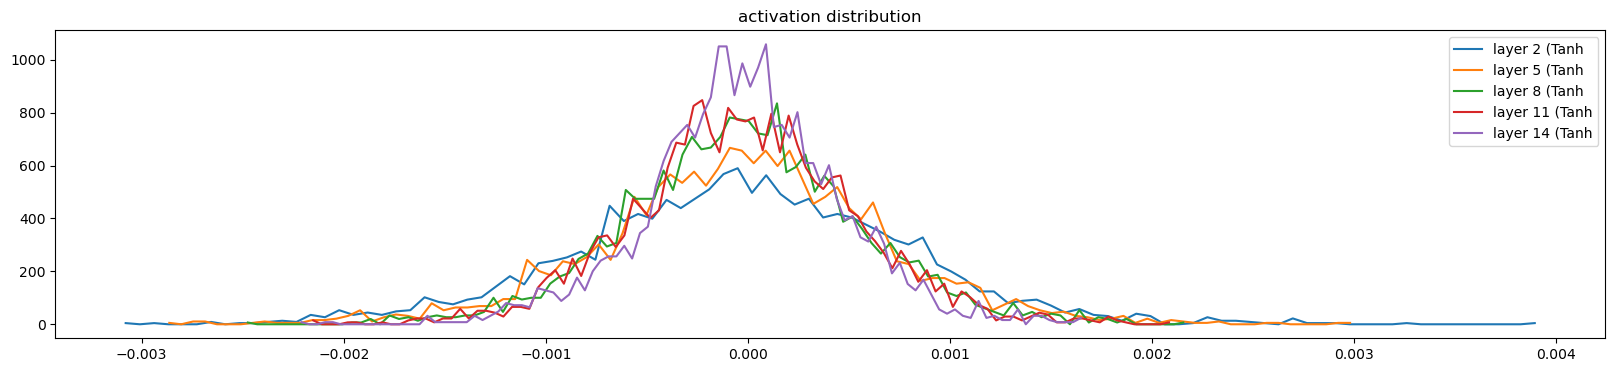

In [93]:
# We visualize histograms of the activations of each layer

plt.figure(figsize=(20, 4)) 
legends = []
for i, layer in enumerate(layers[:-1]): 
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')